<a href="https://colab.research.google.com/github/madhugraj/Procurement_Purchase_Prediction/blob/main/Submission_Procurement_Purchase_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [3]:
# Read the sample data into a pandas DataFrame
data = pd.read_excel(r'/content/drive/MyDrive/Orders.xlsx')

In [38]:
# Duplicate dataframe
data1 = pd.read_excel(r'/content/drive/MyDrive/Orders.xlsx')

# **Exploratory Data Analysis**

In [5]:
# Data Information
print(data.info())
print("\n\n")

# Check the count of unique values in each column
print("Count of unique values in each column:")
print(data.nunique())
print("\n\n")

# Check the missing values in each column
print("Missing values in each column:")
print(data.isnull().sum())
print("\n\n")

# Explore categorical variables
categorical_cols = ['ORDER_STATUS', 'ORDER_CHANNEL', 'SUPPLIER_COUNTRY', 'ORDER_CURRENCY_CODE']
for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(data[col].unique())
    print(f"Value counts in {col}:")
    print(data[col].value_counts())
print("\n\n")

# Explore numerical variables
numerical_cols = ['ORDER_QUANTITY', 'ORDER_UNIT_PRICE', 'ORDER_COST']
for col in numerical_cols:
    print(f"\nStatistics for {col}:")
    print("Minimum:", data[col].min())
    print("Maximum:", data[col].max())
    print("Mean:", data[col].mean())
    print("Median:", data[col].median())
    print("Standard Deviation:", data[col].std())
print("\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85759 entries, 0 to 85758
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ORDER_ID             85759 non-null  object        
 1   ORDER_DATE           85759 non-null  datetime64[ns]
 2   NEED_DATE            85759 non-null  datetime64[ns]
 3   ORDER_STATUS         85759 non-null  object        
 4   ORDER_CHANNEL        85759 non-null  object        
 5   DELY_QTY             31169 non-null  float64       
 6   DELY_DATE            31169 non-null  datetime64[ns]
 7   DELIVERY_SITE        85759 non-null  object        
 8   BUYER_ID             85759 non-null  object        
 9   BUYER_NAME           85759 non-null  object        
 10  SUPPLIER_ID          85759 non-null  object        
 11  SUPPLIER_NAME        85759 non-null  object        
 12  SUPPLIER_COUNTRY     85759 non-null  object        
 13  ITEM_ID              85759 non-

In [6]:
# Top 5 Buyers based on total amount spent
top_buyers = data.groupby('BUYER_NAME')['ORDER_COST'].sum().sort_values(ascending=False).head(5)
print("Top 5 Buyers based on total amount spent:")
print(top_buyers)
print('\n\n')

# Top 5 Suppliers based on total amount received
top_suppliers = data.groupby('SUPPLIER_NAME')['ORDER_COST'].sum().sort_values(ascending=False).head(5)
print("\nTop 5 Suppliers based on total amount received:")
print(top_suppliers)

Top 5 Buyers based on total amount spent:
BUYER_NAME
Shannon Jackson     2.730083e+08
Daniel Nichols      2.566291e+08
Michael Callahan    1.964493e+08
Brian Green         1.919278e+08
Scott Bennett       1.911048e+08
Name: ORDER_COST, dtype: float64




Top 5 Suppliers based on total amount received:
SUPPLIER_NAME
EC Electric                     6.470283e+08
Divine Electric LLC             6.173887e+08
Electric Express                6.170383e+08
NW Wind & Solar                 6.106914e+08
VECA Electric & Technologies    5.986096e+08
Name: ORDER_COST, dtype: float64


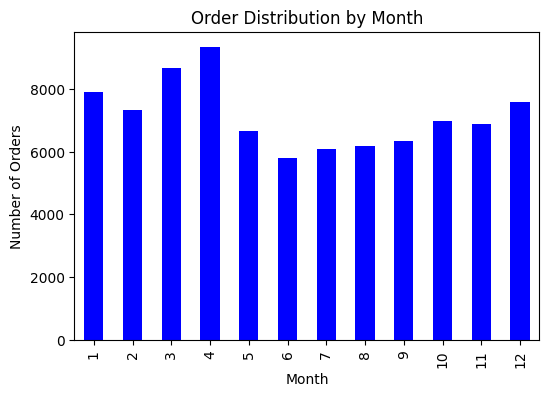

In [7]:
# Order distribution by month
data['ORDER_DATE'] = pd.to_datetime(data['ORDER_DATE'])

# Extract month from 'Order Date'
data['Month'] = data['ORDER_DATE'].dt.month

# Group by month and count the number of orders
monthly_orders = data.groupby('Month').size()

# Plot the order distribution by month
plt.figure(figsize=(6, 4))
monthly_orders.plot(kind='bar', color='blue')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Order Distribution by Month')
plt.show()

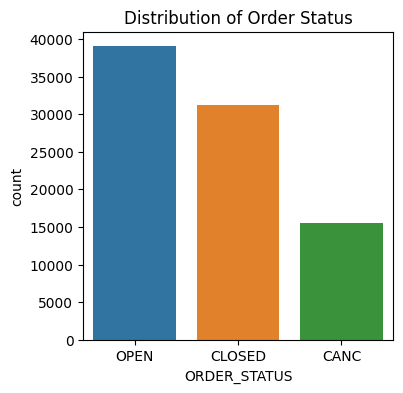

In [8]:
# Distribution of the target variable
plt.figure(figsize=(4, 4))
sns.countplot(x='ORDER_STATUS', data=data)
plt.title('Distribution of Order Status')
plt.show()

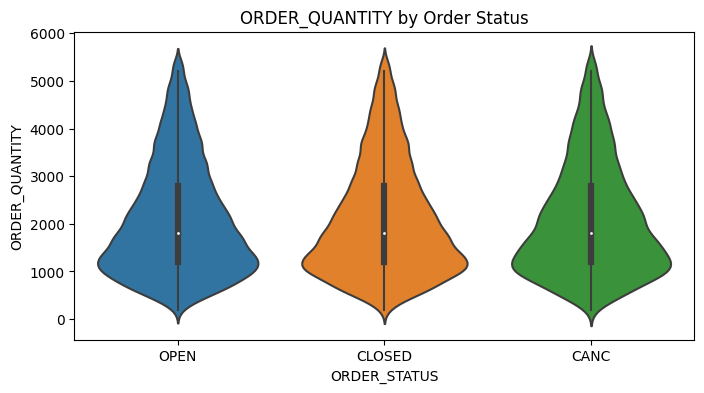

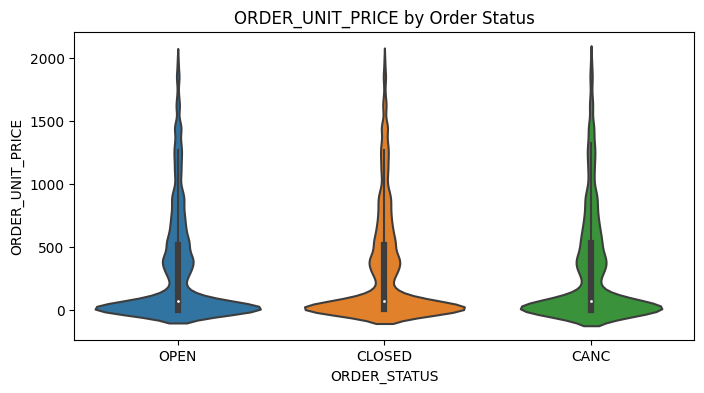

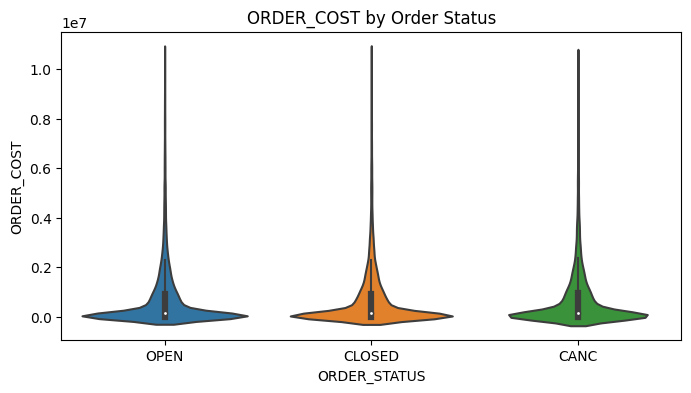

In [10]:
numerical_features = ['ORDER_QUANTITY', 'ORDER_UNIT_PRICE', 'ORDER_COST']

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.violinplot(x='ORDER_STATUS', y=feature, data=data)
    plt.title(f'{feature} by Order Status')
    plt.show()

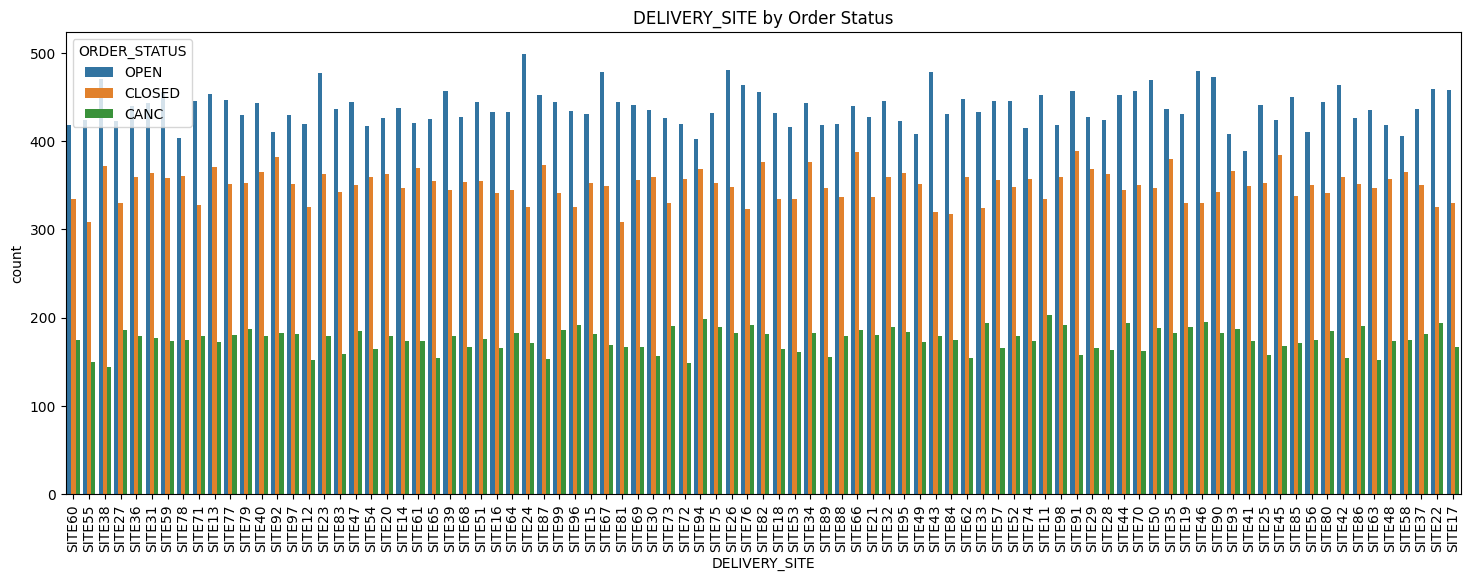

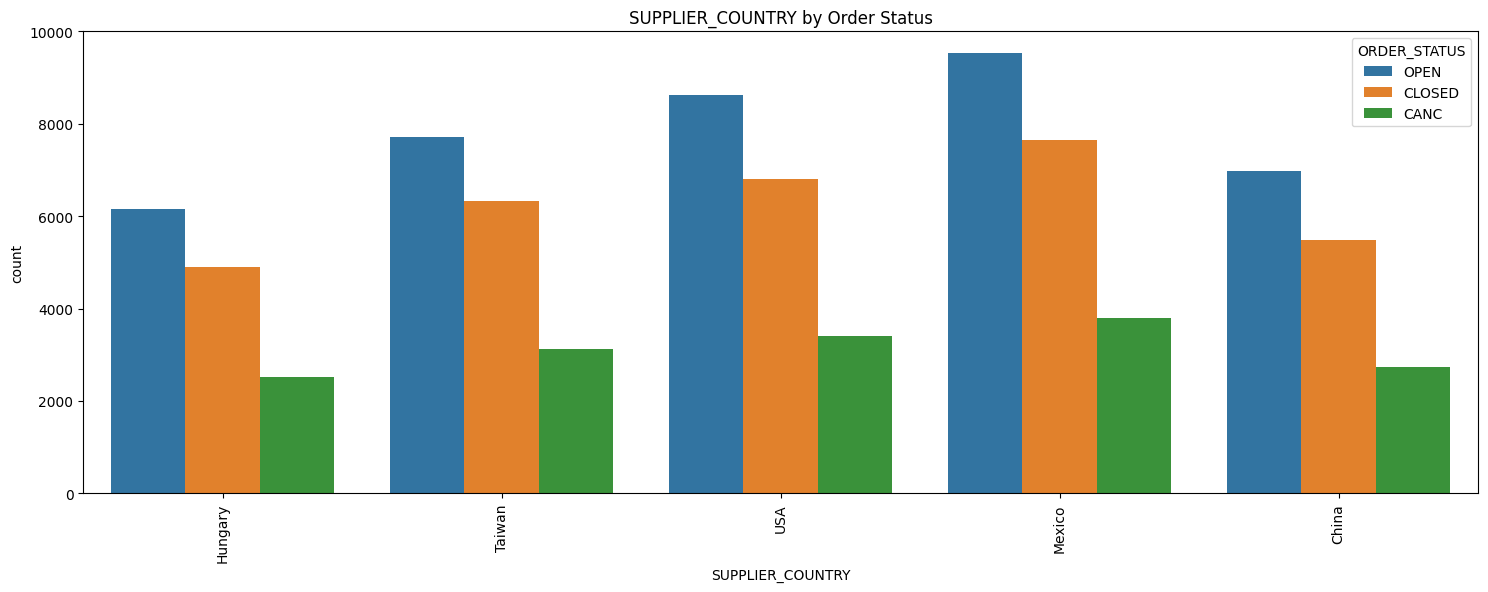

In [11]:
categorical_features = ['DELIVERY_SITE', 'SUPPLIER_COUNTRY']
for feature in categorical_features:
    plt.figure(figsize=(18, 6))
    sns.countplot(x=feature, hue='ORDER_STATUS', data=data)
    plt.title(f'{feature} by Order Status')
    plt.xticks(rotation=90)
    plt.show()

In [13]:
# Calculate the chi-square test of independence

data['ORDER_STATUS'] = data['ORDER_STATUS'].astype('category').cat.codes


categorical_vars = ['DELIVERY_SITE', 'SUPPLIER_COUNTRY', 'ITEM_ID', 'ORDER_STATUS','ORDER_CHANNEL' ,'BUYER_ID','SUPPLIER_ID']
for var in categorical_vars:
    cross_table = pd.crosstab(data[var], data['ORDER_STATUS'])
    chi2, p_value, _, _ = stats.chi2_contingency(cross_table)
    print(f"Chi-square test of independence for {var}:")
    print(f"Chi2 value: {chi2}")
    print(f"P-value: {p_value}\n")

Chi-square test of independence for DELIVERY_SITE:
Chi2 value: 173.65447662614497
P-value: 0.5358539431319053

Chi-square test of independence for SUPPLIER_COUNTRY:
Chi2 value: 6.677618438268236
P-value: 0.5717804797175376

Chi-square test of independence for ITEM_ID:
Chi2 value: 524.7806142430564
P-value: 0.7553159447592004

Chi-square test of independence for ORDER_STATUS:
Chi2 value: 171518.0
P-value: 0.0

Chi-square test of independence for ORDER_CHANNEL:
Chi2 value: 4.4797719858775755
P-value: 0.6120390995202432

Chi-square test of independence for BUYER_ID:
Chi2 value: 837.4504216664104
P-value: 0.9259634592102286

Chi-square test of independence for SUPPLIER_ID:
Chi2 value: 206.37796492029145
P-value: 0.8210821825390068



The interpretation of the chi-square test results is as follows:

**DELIVERY_SITE:**

Chi2 value: 173.65
P-value: 0.54
The chi-square test suggests that there is no significant association between the delivery site and the order status. The p-value is greater than the significance level of 0.05, indicating that the variables are independent.

**SUPPLIER_COUNTRY:**

Chi2 value: 6.68
P-value: 0.57
The chi-square test suggests that there is no significant association between the supplier country and the order status. The p-value is greater than 0.05, indicating independence between the variables.

**ITEM_ID:**

Chi2 value: 524.78
P-value: 0.76
The chi-square test suggests that there is no significant association between the item ID and the order status. The p-value is greater than 0.05, indicating independence.

**ORDER_CHANNEL:**

Chi2 value: 4.48
P-value: 0.61
The chi-square test suggests that there is no significant association between the order channel and the order status. The p-value is greater than 0.05, indicating independence.

**BUYER_ID:**

Chi2 value: 837.45
P-value: 0.93
The chi-square test suggests that there is no significant association between the buyer ID and the order status. The p-value is greater than 0.05, indicating independence.

SUPPLIER_ID:

Chi2 value: 206.38
P-value: 0.82
The chi-square test suggests that there is no significant association between the supplier ID and the order status. The p-value is greater than 0.05, indicating independence.

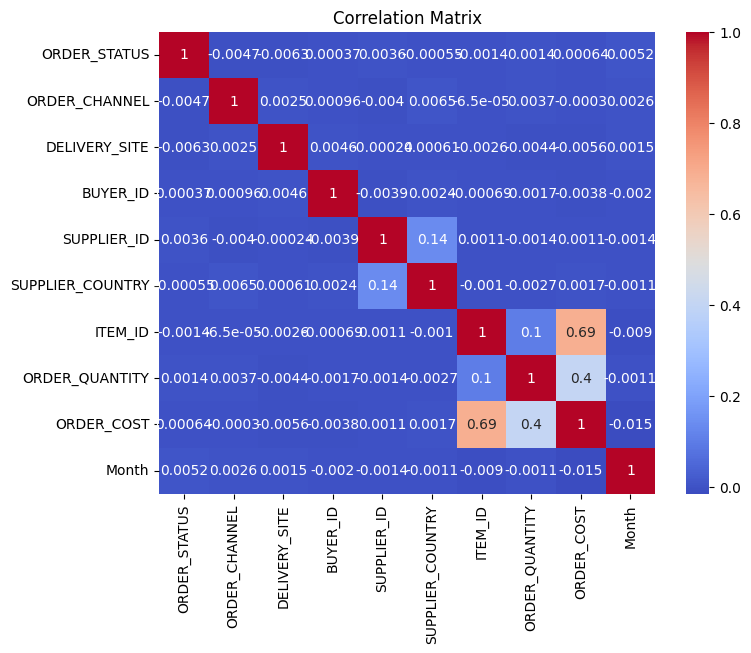

Top 10 Buyer Cancellations:
Daniel Nichols     73
Kevin Elliott      57
Kelly Stewart      56
Marcus Brooks      56
Arthur Thomas      51
James Smith        50
Shannon Jackson    50
Ashley Graham      48
Joshua Jenkins     47
Peter Jones        47
Name: BUYER_NAME, dtype: int64


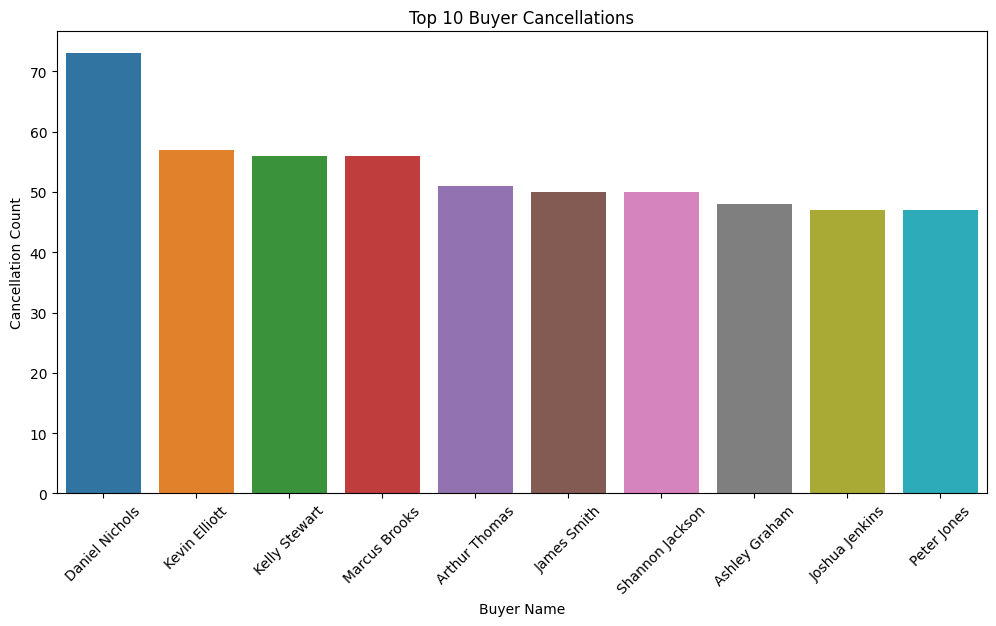

Top 10 Seller Cancellations:
Stusser Electric Company         167
Obot Electric                    161
Sequoyah Electric                160
Essential Electric               158
Positive Voltage                 153
Divine Electric LLC              153
Graybar Electric Supply          153
Electric Express                 153
Wire Craft Electric              153
Cascade Electrical Agents Inc    152
Name: SUPPLIER_NAME, dtype: int64


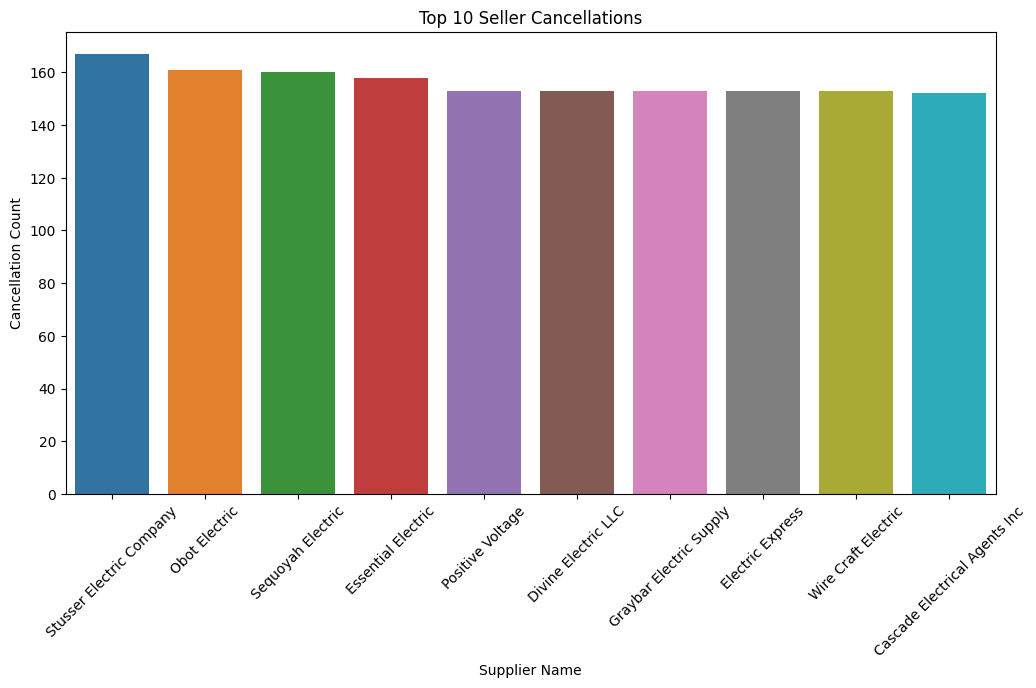

Top 10 Item Cancellations:
HUAWEI DBS3900 Distributed Bas       739
Debugging Integrated Equipment       510
Alienware M15x, Cosmic Black         261
HPPaviliondv7tQuadEditionEnter       218
Caterpiller 3K-X 350W AC Power Su    210
Cisco Caterpiller 3650 24 Port Da    168
Cisco ISR 4331 UC Bundle, PVDM       164
BASE,INSP DT,AIO,2310,CTO            164
HPPaviliondv6tQuadEditionEnter       162
Alienware M15X, Cosmic Black         141
Name: ITEM_DESC, dtype: int64


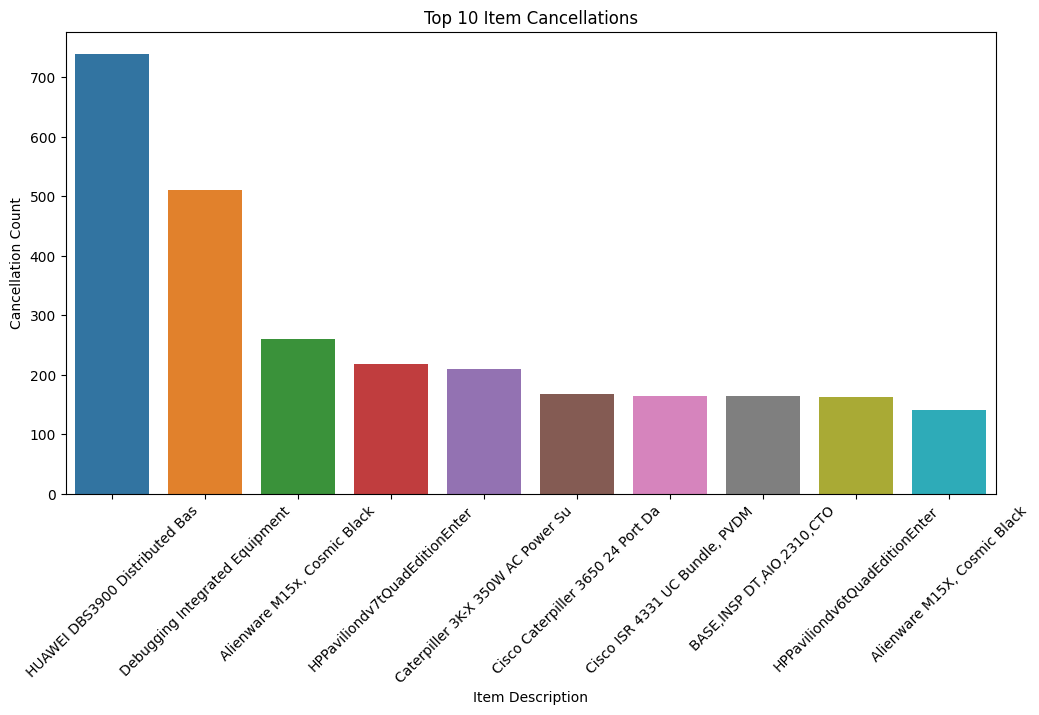


Chi-square test of independence for BUYER_NAME:
BUYER_NAME    Aaron Collier PhD  Aaron Harvey  Adam Johnson  \
ORDER_STATUS                                                  
CANC                         33            29            39   
CLOSED                       74            62            75   
OPEN                        106            94            84   

BUYER_NAME    Adriana Rodriguez  Aimee Davis  Albert Oconnor  Alex Vaughn  \
ORDER_STATUS                                                                
CANC                         40           42              32           36   
CLOSED                       77           66              69           65   
OPEN                         94           87             100           78   

BUYER_NAME    Alexa Johnson  Alexander Gonzalez  Alexander Hernandez  ...  \
ORDER_STATUS                                                          ...   
CANC                     36                  34                   32  ...   
CLOSED            

In [16]:
# Plot the correlation matrix wrt cancellation of purchase 
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Analyze the cancellation distribution for buyers (Top 10)
buyer_cancellations = data1[data1['ORDER_STATUS'] == 'CANC']['BUYER_NAME'].value_counts().head(10)
print("Top 10 Buyer Cancellations:")
print(buyer_cancellations)

# Plot the top 10 buyer cancellations distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=buyer_cancellations.index, y=buyer_cancellations.values)
plt.title('Top 10 Buyer Cancellations')
plt.xlabel('Buyer Name')
plt.ylabel('Cancellation Count')
plt.xticks(rotation=45)
plt.show()

# Analyze the cancellation distribution for sellers/suppliers (Top 10)
seller_cancellations = data1[data1['ORDER_STATUS'] == 'CANC']['SUPPLIER_NAME'].value_counts().head(10)
print("Top 10 Seller Cancellations:")
print(seller_cancellations)

# Plot the top 10 seller cancellations distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=seller_cancellations.index, y=seller_cancellations.values)
plt.title('Top 10 Seller Cancellations')
plt.xlabel('Supplier Name')
plt.ylabel('Cancellation Count')
plt.xticks(rotation=45)
plt.show()

# Analyze the cancellation distribution for items (Top 10)
item_cancellations = data1[data1['ORDER_STATUS'] == 'CANC']['ITEM_DESC'].value_counts().head(10)
print("Top 10 Item Cancellations:")
print(item_cancellations)

# Plot the top 10 item cancellations distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=item_cancellations.index, y=item_cancellations.values)
plt.title('Top 10 Item Cancellations')
plt.xlabel('Item Description')
plt.ylabel('Cancellation Count')
plt.xticks(rotation=45)
plt.show()

# Chi-square test of independence for categorical variables (Buyer Name, Supplier Name, Item Description)
categorical_vars = ['BUYER_NAME', 'SUPPLIER_NAME', 'ITEM_DESC']
for var in categorical_vars:
    contingency_table = pd.crosstab(data1['ORDER_STATUS'], data1[var])
    print(f"\nChi-square test of independence for {var}:")
    print(contingency_table)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")


A correlation coefficient of 0.69 indicates a strong positive relationship between ITEM_ID and ORDER_COST. This means that as one variable increases, the other variable tends to increase as well. 


**Based on these results, the variables of buyer name, supplier name, and item description do not show a significant association with the order status.**

In [23]:
order_counts = data['ORDER_STATUS'].value_counts()
OPEN_Order = order_counts[2]
CLOSE_Order = order_counts[1]
CANC_Order = order_counts[0]

print("Count of ORDER_STATUS:")
print(f"CANCELLED: {CANC_Order}")
print(f"OPEN: {OPEN_Order}")
print(f"CLOSE: {CLOSE_Order}")

Count of ORDER_STATUS:
CANCELLED: 15586
OPEN: 39004
CLOSE: 31169


**Task is to predict if the order would be cancelled or not. The given sample is not evenly distributed. There is a possiblity of sample bias.**

# BUILD MODELS

In [60]:
data = pd.read_excel(r'/content/drive/MyDrive/Orders.xlsx')


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85759 entries, 0 to 85758
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ORDER_ID             85759 non-null  object        
 1   ORDER_DATE           85759 non-null  datetime64[ns]
 2   NEED_DATE            85759 non-null  datetime64[ns]
 3   ORDER_STATUS         85759 non-null  object        
 4   ORDER_CHANNEL        85759 non-null  object        
 5   DELY_QTY             31169 non-null  float64       
 6   DELY_DATE            31169 non-null  datetime64[ns]
 7   DELIVERY_SITE        85759 non-null  object        
 8   BUYER_ID             85759 non-null  object        
 9   BUYER_NAME           85759 non-null  object        
 10  SUPPLIER_ID          85759 non-null  object        
 11  SUPPLIER_NAME        85759 non-null  object        
 12  SUPPLIER_COUNTRY     85759 non-null  object        
 13  ITEM_ID              85759 non-

In [62]:
data.drop(['ORDER_ID', 'NEED_DATE', 'DELY_DATE', 'ORDER_CURRENCY_CODE','ORDER_DATE','ORDER_UNIT_PRICE','ITEM_DESC','SUPPLIER_NAME','BUYER_NAME','DELY_QTY'], axis=1, inplace=True)

# Encode categorical variables
cat_cols = ['DELIVERY_SITE', 'SUPPLIER_COUNTRY', 'ORDER_CHANNEL','BUYER_ID','SUPPLIER_ID','ITEM_ID']
for col in cat_cols:
    data[col] = LabelEncoder().fit_transform(data[col])
data['ORDER_STATUS'] = data['ORDER_STATUS'].apply(lambda x: 1 if x == 'CANC' else 0)

** The order status column from categorical values ('CANC', 'OPEN', 'CLOSED') to binary values (1 for 'CANC' and 0 for 'OPEN' and 'CLOSED'). This transformation is commonly used when dealing with binary classification tasks, where the goal is to predict whether an order will be canceled or not. **

---



In [63]:

# Split the data into training and testing sets
X = data.drop('ORDER_STATUS', axis=1)
y = data['ORDER_STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale the float variables
scaler = StandardScaler()
float_cols = [ 'ORDER_QUANTITY', 'ORDER_COST']
X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
X_test[float_cols] = scaler.transform(X_test[float_cols])


In [65]:
# Define the models

models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC()
}

In [67]:
# Train and evaluate the models
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    print(f"\n{name} Model Evaluation:")
    print(classification_report(y_test, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print('---------------------------------------')


Random Forest Model Evaluation:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     17421
           1       0.22      0.00      0.00      4019

    accuracy                           0.81     21440
   macro avg       0.52      0.50      0.45     21440
weighted avg       0.70      0.81      0.73     21440

Confusion Matrix:
[[17414     7]
 [ 4017     2]]
---------------------------------------

XGBoost Model Evaluation:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     17421
           1       0.18      0.00      0.00      4019

    accuracy                           0.81     21440
   macro avg       0.49      0.50      0.45     21440
weighted avg       0.69      0.81      0.73     21440

Confusion Matrix:
[[17379    42]
 [ 4010     9]]
---------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit


Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     17421
           1       0.00      0.00      0.00      4019

    accuracy                           0.81     21440
   macro avg       0.41      0.50      0.45     21440
weighted avg       0.66      0.81      0.73     21440

Confusion Matrix:
[[17421     0]
 [ 4019     0]]
---------------------------------------

SVM Model Evaluation:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     17421
           1       0.00      0.00      0.00      4019

    accuracy                           0.81     21440
   macro avg       0.41      0.50      0.45     21440
weighted avg       0.66      0.81      0.73     21440

Confusion Matrix:
[[17421     0]
 [ 4019     0]]
---------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


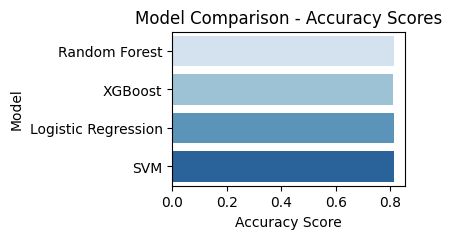

In [68]:
# Compare model performance with visualization
model_names = list(models.keys())
accuracy_scores = [models[name].score(X_test, y_test) for name in model_names]

plt.figure(figsize=(3, 2))
sns.barplot(x=accuracy_scores, y=model_names, palette='Blues')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.title('Model Comparison - Accuracy Scores')
plt.show()

<ipython-input-70-e1826b3f1aa5>:18: RuntimeWarning: invalid value encountered in true_divide
  weighted_precision = (tp / (tp + fp)).mean()
<ipython-input-70-e1826b3f1aa5>:18: RuntimeWarning: invalid value encountered in true_divide
  weighted_precision = (tp / (tp + fp)).mean()


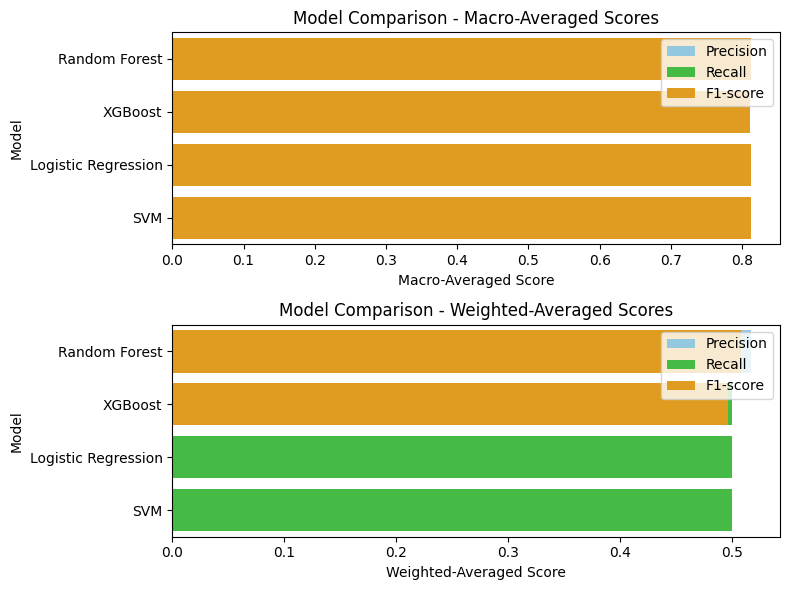

In [70]:
model_names = list(models.keys())
macro_precision_scores = []
macro_recall_scores = []
macro_f1_scores = []
weighted_precision_scores = []
weighted_recall_scores = []
weighted_f1_scores = []

for name in model_names:
    predictions = models[name].predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    tp = cm.diagonal()
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    macro_precision = tp.sum() / (tp.sum() + fp.sum())
    macro_recall = tp.sum() / (tp.sum() + fn.sum())
    macro_f1 = 2 * macro_precision * macro_recall / (macro_precision + macro_recall)
    weighted_precision = (tp / (tp + fp)).mean()
    weighted_recall = (tp / (tp + fn)).mean()
    weighted_f1 = 2 * weighted_precision * weighted_recall / (weighted_precision + weighted_recall)
    macro_precision_scores.append(macro_precision)
    macro_recall_scores.append(macro_recall)
    macro_f1_scores.append(macro_f1)
    weighted_precision_scores.append(weighted_precision)
    weighted_recall_scores.append(weighted_recall)
    weighted_f1_scores.append(weighted_f1)

# Plotting macro-averaged scores
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
sns.barplot(x=macro_precision_scores, y=model_names, color='skyblue', label='Precision')
sns.barplot(x=macro_recall_scores, y=model_names, color='limegreen', label='Recall')
sns.barplot(x=macro_f1_scores, y=model_names, color='orange', label='F1-score')
plt.xlabel('Macro-Averaged Score')
plt.ylabel('Model')
plt.title('Model Comparison - Macro-Averaged Scores')
plt.legend()

# Plotting weighted-averaged scores
plt.subplot(2, 1, 2)
sns.barplot(x=weighted_precision_scores, y=model_names, color='skyblue', label='Precision')
sns.barplot(x=weighted_recall_scores, y=model_names, color='limegreen', label='Recall')
sns.barplot(x=weighted_f1_scores, y=model_names, color='orange', label='F1-score')
plt.xlabel('Weighted-Averaged Score')
plt.ylabel('Model')
plt.title('Model Comparison - Weighted-Averaged Scores')
plt.legend()

plt.tight_layout()
plt.show()


All the models achieves an overall accuracy of 0.81, indicating decent overall performance. However, when considering the performance across individual classes, the model's performance is relatively poor in terms of precision, recall, and F1-score (as indicated by macro-average). The weighted-average scores provide a more representative evaluation, accounting for class imbalance, and show better performance compared to the macro-average scores. Of these Random Forest has a better Macro avg.

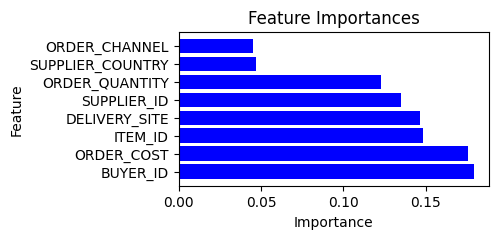

In [71]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier to the data
rf_classifier.fit(X, y)

# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances.sort_values('Importance', ascending=False, inplace=True)

# Plot feature importances
plt.figure(figsize=(4, 2))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# Feature Engineering

** OVER SAMPLING **

In [72]:
data = pd.read_excel(r'/content/drive/MyDrive/Orders.xlsx')

# Drop irrelevant columns
columns_to_drop = ['ORDER_ID', 'NEED_DATE', 'DELY_DATE', 'ORDER_CURRENCY_CODE', 'ORDER_DATE', 'ORDER_UNIT_PRICE', 'ITEM_DESC', 'SUPPLIER_NAME', 'BUYER_NAME', 'DELY_QTY']
data = data.drop(columns_to_drop, axis=1)

# Combine "OPEN" and "CLOSED" as one group, and "CANC" as the other group
data['ORDER_STATUS'] = np.where(data['ORDER_STATUS'].isin(['OPEN', 'CLOSED']), 'NOT CANCELLED', 'CANCELLED')

# Separate features and target variable
X = data.drop('ORDER_STATUS', axis=1)
y = data['ORDER_STATUS']

# Encode categorical variables using LabelEncoder
label_encoder = LabelEncoder()
X_encoded = X.copy()

# Encode categorical variables
categorical_columns = ['ORDER_CHANNEL', 'DELIVERY_SITE', 'BUYER_ID', 'SUPPLIER_ID', 'SUPPLIER_COUNTRY', 'ITEM_ID']
for col in categorical_columns:
    X_encoded[col] = label_encoder.fit_transform(X[col])

# Perform oversampling to address class imbalance
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_encoded, y)

# Train the random forest classifier with undersampled data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# Perform train-test split on the resampled data 40% test data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42, stratify=y_resampled)

# Scale the numeric features
numeric_columns = ['ORDER_QUANTITY', 'ORDER_COST']
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Fit the random forest classifier on the training data
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


# Calculate feature importances
importances = classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print feature importance rankings
print("Feature Importance Rankings:")
for i, index in enumerate(indices):
    print(f"{i+1}. {X_encoded.columns[index]}: {importances[index]}")

               precision    recall  f1-score   support

    CANCELLED       0.95      0.96      0.95     28070
NOT CANCELLED       0.96      0.95      0.95     28069

     accuracy                           0.95     56139
    macro avg       0.95      0.95      0.95     56139
 weighted avg       0.95      0.95      0.95     56139

Feature Importance Rankings:
1. BUYER_ID: 0.17681461643115418
2. ORDER_COST: 0.17035682360313784
3. DELIVERY_SITE: 0.14798785392857233
4. ITEM_ID: 0.14624729742116852
5. SUPPLIER_ID: 0.14018850294725949
6. ORDER_QUANTITY: 0.12374550556568878
7. SUPPLIER_COUNTRY: 0.04973829008250118
8. ORDER_CHANNEL: 0.04492111002051772


In [76]:
# Define label encoders
buyer_encoder = LabelEncoder()
seller_encoder = LabelEncoder()
#item_desc_encoder = LabelEncoder()

# Fit label encoders on respective columns
buyer_encoder.fit(data['BUYER_ID'])
seller_encoder.fit(data['SUPPLIER_ID'])
#item_desc_encoder.fit(data['ITEM_ID'])

# Get input from the user
buyer_id = input("Enter Buyer ID: ")
seller_id = input("Enter Seller ID: ")
#item_id = input("Enter Item ID: ")

# Encode categorical variables
buyer_id_encoded = buyer_encoder.transform([buyer_id])[0]
seller_id_encoded = seller_encoder.transform([seller_id])[0]
#item_id_encoded = item_desc_encoder.transform([item_id])[0]

# Create input array
input_data = np.array([[buyer_id_encoded, seller_id_encoded, 0, 0, 0, 0, 0, 0]])

# Make prediction
prediction = classifier.predict(input_data)[0]

# Decode prediction
if prediction == 1:
    order_status = "CANCELLED"
else:
    order_status = "NOT CANCELLED"

# Decode buyer ID, seller ID, and item ID
buyer_id_decoded = buyer_encoder.inverse_transform([buyer_id_encoded])[0]
seller_id_decoded = seller_encoder.inverse_transform([seller_id_encoded])[0]
#item_id_decoded = item_desc_encoder.inverse_transform([item_id_encoded])[0]

# Print prediction and details
print("Prediction Details:")
print(f"Buyer ID: {buyer_id_decoded}")
print(f"Seller ID: {seller_id_decoded}")
#print(f"Item ID: {item_id_decoded}")
print(f"Predicted Order Status: {order_status}")

Enter Buyer ID: TSB0397
Enter Seller ID: SUP00141
Prediction Details:
Buyer ID: TSB0397
Seller ID: SUP00141
Predicted Order Status: NOT CANCELLED


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


**Under Sampling**

In [77]:
data = pd.read_excel(r'/content/drive/MyDrive/Orders.xlsx')

# Drop irrelevant columns
columns_to_drop = ['ORDER_ID', 'NEED_DATE', 'DELY_DATE', 'ORDER_CURRENCY_CODE', 'ORDER_DATE', 'ORDER_UNIT_PRICE', 'ITEM_DESC', 'SUPPLIER_NAME', 'BUYER_NAME', 'DELY_QTY']
data = data.drop(columns_to_drop, axis=1)

# Combine "OPEN" and "CLOSED" as one group, and "CANC" as the other group
data['ORDER_STATUS'] = np.where(data['ORDER_STATUS'].isin(['OPEN', 'CLOSED']), 'NOT CANCELLED', 'CANCELLED')

# Separate features and target variable
X = data.drop('ORDER_STATUS', axis=1)
y = data['ORDER_STATUS']

# Encode categorical variables using LabelEncoder
label_encoder = LabelEncoder()
X_encoded = X.copy()

# Encode categorical variables
categorical_columns = ['ORDER_CHANNEL', 'DELIVERY_SITE', 'BUYER_ID', 'SUPPLIER_ID', 'SUPPLIER_COUNTRY', 'ITEM_ID']
for col in categorical_columns:
    X_encoded[col] = label_encoder.fit_transform(X[col])

# Perform undersampling to address class imbalance
undersampler = RandomUnderSampler(random_state=42)
#X_resampled, y_resampled = undersampler.fit_resample(X_encoded.drop('ORDER_STATUS', axis=1), X_encoded['ORDER_STATUS'])

X_resampled, y_resampled = undersampler.fit_resample(X_encoded, y)

# Perform train-test split on the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42, stratify=y_resampled)

# Scale the numeric features
numeric_columns = ['ORDER_QUANTITY', 'ORDER_COST']
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Fit the random forest classifier on the training data
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)


# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


# Calculate feature importances
importances = classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print feature importance rankings
print("Feature Importance Rankings:")
for i, index in enumerate(indices):
    print(f"{i+1}. {X_encoded.columns[index]}: {importances[index]}")


               precision    recall  f1-score   support

    CANCELLED       0.50      0.53      0.51      1559
NOT CANCELLED       0.50      0.46      0.48      1559

     accuracy                           0.50      3118
    macro avg       0.50      0.50      0.50      3118
 weighted avg       0.50      0.50      0.50      3118

Feature Importance Rankings:
1. BUYER_ID: 0.17189282559302477
2. ORDER_COST: 0.16881617760962886
3. DELIVERY_SITE: 0.14832800634902077
4. ITEM_ID: 0.14554302917843825
5. SUPPLIER_ID: 0.13958171614009574
6. ORDER_QUANTITY: 0.12746216996827456
7. SUPPLIER_COUNTRY: 0.050346035043675644
8. ORDER_CHANNEL: 0.04803004011784158


In [78]:
# Define label encoders
buyer_encoder = LabelEncoder()
seller_encoder = LabelEncoder()
#item_desc_encoder = LabelEncoder()

# Fit label encoders on respective columns
buyer_encoder.fit(data['BUYER_ID'])
seller_encoder.fit(data['SUPPLIER_ID'])
#item_desc_encoder.fit(data['ITEM_ID'])

# Get input from the user
buyer_id = input("Enter Buyer ID: ")
seller_id = input("Enter Seller ID: ")
#item_id = input("Enter Item ID: ")

# Encode categorical variables
buyer_id_encoded = buyer_encoder.transform([buyer_id])[0]
seller_id_encoded = seller_encoder.transform([seller_id])[0]
#item_id_encoded = item_desc_encoder.transform([item_id])[0]

# Create input array
input_data = np.array([[buyer_id_encoded, seller_id_encoded, 0, 0, 0, 0, 0, 0]])

# Make prediction
prediction = classifier.predict(input_data)[0]

# Decode prediction
if prediction == 1:
    order_status = "CANCELLED"
else:
    order_status = "NOT CANCELLED"

# Decode buyer ID, seller ID, and item ID
buyer_id_decoded = buyer_encoder.inverse_transform([buyer_id_encoded])[0]
seller_id_decoded = seller_encoder.inverse_transform([seller_id_encoded])[0]
#item_id_decoded = item_desc_encoder.inverse_transform([item_id_encoded])[0]

# Print prediction and details
print("Prediction Details:")
print(f"Buyer ID: {buyer_id_decoded}")
print(f"Seller ID: {seller_id_decoded}")
#print(f"Item ID: {item_id_decoded}")
print(f"Predicted Order Status: {order_status}")

Enter Buyer ID: TSB0397
Enter Seller ID: SUP00141
Prediction Details:
Buyer ID: TSB0397
Seller ID: SUP00141
Predicted Order Status: NOT CANCELLED


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


It is observed that neither upsampling nor downsampling works good! Model is either overfitting or underfitting.